# Bayes Theorem



Let us recall the context and our goal:


* Science is deeply interested in questions of the form: given data collected in the world, what can we say about the data-generating process(es)? That is, what is $P(M|D)$, the probability of any model $M$, given the observed/collected data $D$?
* On the other hand, statistics and probability are better at answering questions such as: given the model $M$, what is the probability $P(D|M)$ of observing the data $D$?

To get out of this slightly paradoxical situation, we will require tools that allow us to move between $P(D|M)$ and $P(M|D)$. It will eventually be Bayesian inference that allows us to do so, and we'll see precisely how in the next chapter. In this chapter, we'll lay the groundwork by introducing Bayes Theorem, they fundamental result of Bayesian inference, after reminding ourselves and the reader a bit about joint and conditional probabilities.

## Joint probability

We expect that the reader may be quite familiar with joint and conditional probabilities. If so, feel free to skip these sections, however they may be both interesting and informative.

We have already encountered joint probabilities above, perhaps without knowing it: $P(A,B)$ is the probability two events $A$ and $B$ both occurring.

- For example, getting two heads in a row.

If $A$ and $B$ and are independent, then $P(A,B)=P(A)P(B)$ but be warned: this is not always (or often) the case.

One way to think of this is considering "AND" as multiplication: the probability of A and B is the probability of A multiplied by the probability of B.



### Example: Joint probability coin flipping

As a toy example, let's now verify that $P(A,B)=P(A)P(B)$ in the two fair coin-flip case (A=heads, B=heads). We do this by 
- first simulating two coins being flipped together and calculating the proportion of occurences with two heads;
- then simulating one coin flip and calculating the proportion of heads and then doing that again and multiplying the two proportions.

Your two calculations should give "pretty close" results and not the same results due to the (in)accuracy of simulation. 

In [1]:
#| output: false
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

In [2]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points
    n = len(data)

    # x-data for the ECDF
    x = np.sort(data)

    # y-data for the ECDF
    y = np.arange(1, n+1) / n

    return x, y

0.2442


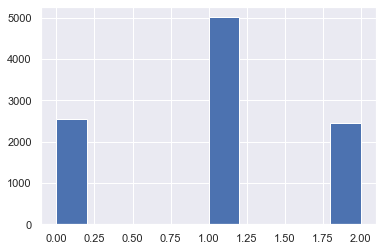

In [3]:
# Solution: Calculate P(A,B)
rng = np.random.default_rng(42)
x_0 = rng.binomial(2, 0.5, 10000)
p_ab = sum(x_0==2)/len(x_0)
plt.hist(x_0);
print(p_ab)

In [4]:
# Solution: Calculate P(A)P(B)
x_1 = rng.binomial(1, 0.5, 10000)
x_2 = rng.binomial(1, 0.5, 10000)
p_a = sum(x_1 == 1)/len(x_1)
p_b = sum(x_2 == 1)/len(x_2)
p_a*p_b

0.25471309000000003

**Note:** In order to use such simulation and _hacker statistics_ approaches to "prove" results such as the above, we're gliding over several coupled and deep technicalities. This is in the interests of the pedagogical nature of this introduction. For the sake of completeness, note that we're essentially
- Using the proportion in our simulations as a proxy for the probability (which, although frequentist, is useful to allow you to start getting your hands dirty with probability via simluation).

Having stated this, for ease of instruction, we'll continue to do so when thinking about joint & conditional probabilities of both simulated and real data. 

### Example: joint probability for birds

We can answer similar questions about empirical data, such as: what is the probability that two randomly selected birds from our Finch data have beak depths over 10 ?

In [5]:
# Import and view head of data
df_12 = pd.read_csv('../../data/finch_beaks_2012.csv')
df_12.head()
# Store lengths in a pandas series
lengths = df_12['blength']

In [6]:
# Calculate P(A)P(B) of two birds having beak lengths > 10
p_a = (sum(lengths > 10))/len(lengths)
p_b = (sum(lengths > 10))/len(lengths)
p_a*p_b

0.724891534007516

This is sampling the dataset itself. We can also use the bootstrap over many random samples to compute these. 

In this spirit, we now calculate the joint probability using the resampling method, that is, by drawing random samples (with replacement) from the data. First we calculate $P(A)P(B)$:

In [7]:
# Calculate P(A)P(B) using resampling methods
n_samples = 100000
p_a = sum(rng.choice(lengths, n_samples, replace=True) > 10)/n_samples
p_b = sum(rng.choice(lengths, n_samples, replace=True) > 10)/n_samples
p_a*p_b

0.7255206086

Now we calculate $P(A,B)$:

In [8]:
# Calculate P(A,B) using resampling methods
n_samples = 100000
samples = rng.choice(lengths, (n_samples,2), replace=True)
_ = samples > (10, 10)
p_ab = sum(np.prod(_, axis=1))/n_samples
p_ab

0.72389

From these simulations, we see that $P(A)P(B)$ and $P(A,B)$ are approximately the same, as we would expect, given their independence.

### Joint probabilities and multivariate data

To think about joint probabilities, let's look at our Finch beak dataset and check out beak lengths and beak depths across the population. We'll be using Seaborn to produce some basic statistical figures to get a sense of this multivariate distribution:


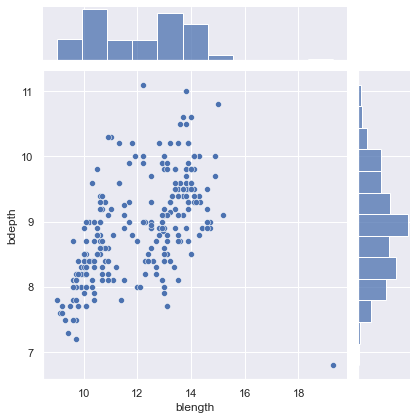

In [9]:
sns.jointplot(data=df_12, x="blength", y="bdepth");

In a joint plot, we see a scatter plot of the two variables, along with histograms of each. Immediately we see that the variables are likely correlated (and hence not independent!). We also see an outlier in the bottom right, so let's just keep this in the back of our mind. Let's drill a bit deeper by plotting our join plot and colouring points with respect to their species:

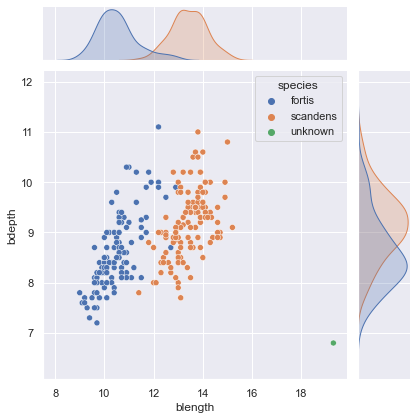

In [10]:
sns.jointplot(data=df_12, x="blength", y="bdepth", hue="species");

Suddenly we see that the outlier is of species unknown! As we wish to concentrate on our two species Fortis and Scandens, we'll drop this data point for the time being:

In [11]:
df = df_12[df_12['species'] != 'unknown']

Also note that the two species look relatively distinct in the scatter plot. They also look quite separated in the beak length KDE but not so much in the beak depth KDE. To see the power of jointplots and the ease of the Seaborn API, we can plot a contour plot:

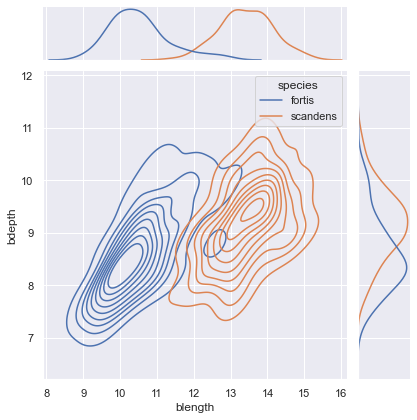

In [12]:
sns.jointplot(data=df, x="blength", y="bdepth", hue="species", kind="kde");

And we can also include a linear regression:

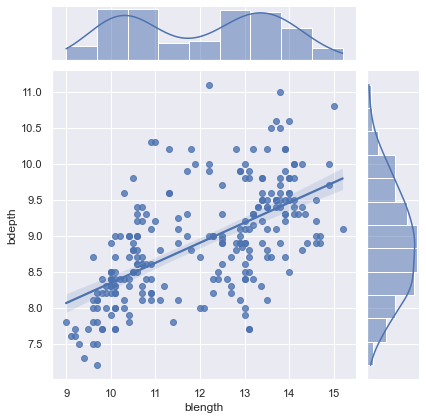

In [13]:
sns.jointplot(data=df, x="blength", y="bdepth", kind="reg");

As we noted earlier, the beak length and depth _look_ correlated but are they? To begin answering this question, let's first compute their Pearson correlation coefficient:

In [14]:
x = df.blength
y = df.bdepth
r = np.corrcoef(np.stack([x, y]))[0,1]
print(r)          

0.6057479578552036


A correlation of 0.6 is relatively strong correlation but, once again, it is important to ask how certain are we of this estimate?
To answer this, we can once again use the bootstrap method to resample from the dataset and compute correlation coefficients of the bootstrapped samples. We'll also plot the resulting histogram and compute the 95% confidence interval:

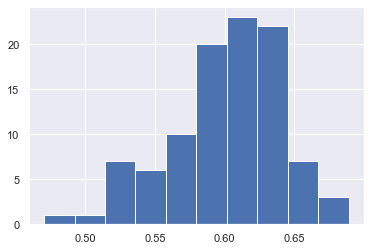

In [15]:
n = 10**2

cc = np.empty(n)

for i in range(n):
    i_s = rng.choice(np.arange(len(x)), len(x))
    x_s = x[i_s]
    y_s = y[i_s]
    yoi = np.stack([x_s, y_s], axis=0)
    cc[i] = np.corrcoef(yoi)[0,1]
    #print(cc)
#plt.hist(cc);
x_1, y_1 = ecdf(cc)
plt.hist(cc);

In [16]:
# 95% CIs
np.percentile(cc, [2.5, 97.5])

array([0.52480273, 0.66971759])

We see that, 95% of the time, our correlation coefficient was between 0.54 and 0.68. Once again note that we're using the bootstrap for EDA to get a sense of what's in our data (but not to make inferences!) 

## Conditional Probability

Now that we have a grasp on joint probabilities, lets consider conditional probabilities, that is, the probability of some $A$, knowing that some other $B$ is true. We use the notation $P(A|B)$ to denote this. 

Conditional and joint probabilites are related by the following:
$$ P(A,B) = P(A|B)P(B).$$


Why do we care about conditional probabilities? There are many reasons! One of the first is that they allow us to ask and answer questions such as "What is the probability of a finch beak having length $>10$, knowing that the finch is of species 'fortis'?"

### Example: conditional probability for birds

1. What is the probability of a finch beak having length > 10 ?
2. What if we know the finch is of species 'fortis'?
3. What if we know the finch is of species 'scandens'?

In [17]:
sum(df_12.blength > 10)/len(df_12)

0.8514056224899599

In [18]:
df_fortis = df_12.loc[df_12['species'] == 'fortis']
blf = df_fortis.blength
sum(df_fortis.blength > 10)/len(df_fortis)

0.6942148760330579

In [19]:
df_scandens = df_12.loc[df_12['species'] == 'scandens']
sum(df_scandens.blength > 10)/len(df_scandens)

1.0

**Note:** These proportions between species are definitely different. We can't say much more currently but we'll soon see how to use hypothesis testing to see what else we can say about the differences between the species of finches.

### Bootstrapping for conditional probabilites

As we have developed our bootstrapping skills this far, it would be a shame to not leverage them to think about these questions. To this end, we now use the bootstrap to compute boostrapped probabilities of fortis finch beaks having length > 10:

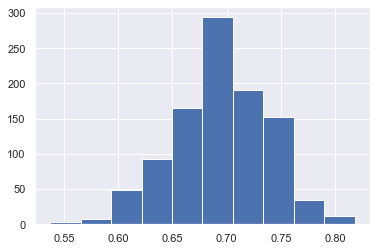

In [20]:
n = 10**3
cp = np.zeros(n)


for i in np.arange(n):
    cp[i] = sum(rng.choice(blf, len(blf)) > 10)/len(blf)

plt.hist(cp);

Now that we have developed a bit more intution behind both joint and conditional probabilities, it's time to arrive at Bayes' Theorem!

##  Bayes' Theorem

Let us first state Bayes' theorem. Then we shall prove it and demonstrate its utility. 

$$P(B|A) = \frac{P(A|B)P(B)}{P(A)}$$

As we have stated several times by now, it is Bayes' Theorem that will allow us to move back and forth between $P(data|model)$ and $P(model|data)$. As we have seen, $P(model|data)$ is usually what we're interested in as data scientists yet $P(data|model)$ is what we can easily compute, either by simulating our model or using analytic equations.

One of the coolest things is that Bayes Theorem can be proved with a few lines of mathematics. Let's do it!

Recall that conditional and joint probabilites are related by the following:
$$ P(A,B) = P(A|B)P(B).$$

By symmetry, this implies that

$$P(B,A) = P(B|A)P(A).$$

Dividing both sides by $P(A)$ yields

$$P(B|A) = \frac{P(B,A)}{P(B)}.$$ 

But $P(B,A) = P(A, B)$ and thus, from the first equation above,  $P(B,A) = P(A|B)P(B),$ implying that

$$P(B|A) = \frac{P(A|B)P(B)}{P(A)}$$

and this is Bayes' Theorem!


Let's now show how it can be applied in a practical setting by returning to our 'test for infectious disease' example from Chapter 3.


### Example: Test for infectious disease

Recall our example from Chapter 3:

> Suppose that a test for an infectious disease X has 99% sensitivity (true positive rate) and 99% specificity (true negative rate), that is, a 1% false positive rate and 1% false negative rate. Suppose that 0.5% (5 in 1,000) of people have X. What is the probability that a randomly selected individual with a positive test has X?

Also recall that, **If we can answer this, it will be really cool as it shows how we can move from knowing $P(+|disease)$ to $P(disease|+)$, a MVP for being able to move from $P(data|model)$ to $P(model|data)$.**

We solved this challenge using random sampling previously:

In [21]:
# Take 10,000 subjects
n = 100000
# Sample for number with X and without X
X = rng.binomial(n, 0.005, 1) 
not_X = n - X
# How many of those with X tested +ve ?
X_pos = rng.binomial(X, 0.99)
# How many of those without X tested +ve ?
non_pos = rng.binomial(not_X, 0.01)
# how many of those +ve tests were for people with X?
X_pos/(X_pos+non_pos)

array([0.34147997])

### Bayes Theorem solves the above infectious disease testing problem

Bayes Theorem can be used to analytically derive the solution to the 'infectious disease' example above as follows.

From Bayes Theorem, 

$$P(disease|+) = \frac{P(+|disease)P(disease)}{P(+)}$$



We can expand the denominator here into 

$$P(+)  = P(+,disease) + P(+,no-disease) $$

so that

$$ P(+)=P(+|disease)P(disease) + P(+|no-disease)P(no-disease)$$

and 

$$P(disease|+) = \frac{P(+|disease)P(disease)}{P(+|disease)P(disease) + P(+|no-disease)P(no-disease)}.$$

Calculating this explicitly yields

$$P(disease|+) = \frac{0.99\times 0.005}{0.99\times 0.005 + 0.01\times 0.995} = 0.332 $$

This means that if an individual tests positive, there is still only a 33.2% chance that they are have the disease! This is because the number of non-disease is so high compared to the number of disease.

## Wrapping up

In this notebook, we have introduced Bayes Theorem via reminders about joint and conditional probabilities. We have proved Bayes' Theorem and discussed how it lays the foundation to moving between $P(D|M)$ and $P(M|D)$, a basic concern of science and inference. We have also demonstrated its utility in the specific example of testing for infectious disease. In the next chapter, we'll see how Bayes Theorem gives rise to the basic building blocks of Bayesian inference.